In [ ]:
!python3.10 -m pip install scikit-learn 
!python3.10 -m pip install nltk 
!python3.10 -m pip install spacy
!python3.10 -m pip install pandas
!python3.10 -m pip install fasttext-wheel
!python3.10 -m pip install matplotlib
!python3.10 -m pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [6]:
import pandas as pd
import os
import re
import string
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
path = "/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/Files"
pathUserInfo = path + "/files/treino"
pathNewsInfo = path + "/itens/itens"

def readCsv(path):
    dataframes = []
    for file in os.listdir(path):
        caminho_arquivo = os.path.join(path, file)
        if file.endswith(".csv"):
            df = pd.read_csv(caminho_arquivo)
            dataframes.append(df)
    df_final = pd.concat(dataframes, ignore_index=True)
    return df_final

usersInfo = readCsv(pathUserInfo)
newsInfo = readCsv(pathNewsInfo)

In [8]:
newsInfo.head(1).values.tolist()

[['13db0ab1-eea2-4603-84c4-f40a876c7400',
  'http://g1.globo.com/am/amazonas/noticia/2022/06/18/caso-bruno-e-dom-3o-suspeito-tem-prisao-temporaria-decretada-pela-justica-do-am.ghtml',
  '2022-06-18 20:37:45+00:00',
  '2023-04-15 00:02:08+00:00',
  'Caso Bruno e Dom: 3º suspeito tem prisão temporária decretada pela Justiça do AM',
  'Após audiência de custódia, a Justiça do Amazonas decretou, na tarde deste sábado (18), a prisão temporária,  por 30 dias, de Jeferson da Silva Lima, conhecido como "Pelado da Dinha". Ele teve participação direta na morte do indigenista Bruno Pereira e do jornalista inglês Dom Phillips, aponta as investigações. \n"Pelado da Dinha" foi considerado foragido na noite de sexta-feira (17) após ter o mandado de prisão expedido e não ser localizado pelas autoridades. Ele se entregou na delegacia de Atalaia do Norte, a 1.136 quilômetros de Manaus, nas primeiras horas da manhã deste sábado, onde foi ouvido pelo delegado Alex Perez Timóteo. \n"Pelado da Dinha" foi co

In [9]:
print(usersInfo.shape)
print(newsInfo.shape)

(577942, 10)
(255603, 7)


In [10]:
#Limpesa dos dados
def clear_dataframes(df:pd.DataFrame):
    df = df.dropna()
    df = df.drop_duplicates()
    if("timestampHistory_new" in df.columns):
        df = df.drop(columns=["timestampHistory_new"])
    return df

usersInfo = clear_dataframes(usersInfo)
newsInfo = clear_dataframes(newsInfo)



In [11]:
#Ajustando tipos 
def convert_to_list(value, dtype):
    if pd.isna(value) or value == '':
        return []
    return list(map(dtype, value.split(',')))

def ajusting_types(df:pd.DataFrame, value):
    if(value):
        df['userId'] = df['userId'].astype('string')
        df['userType'] = df['userType'].astype('category')
        df['historySize'] = df['historySize'].astype('Int64')
        df['history'] = df['history'].apply(lambda x: convert_to_list(x, str))      
        df['timestampHistory'] = df['timestampHistory'].apply(lambda x: convert_to_list(x, int))
        df['numberOfClicksHistory'] = df['numberOfClicksHistory'].apply(lambda x: convert_to_list(x, int))
        df['timeOnPageHistory'] = df['timeOnPageHistory'].apply(lambda x: convert_to_list(x, int))
        df['scrollPercentageHistory'] = df['scrollPercentageHistory'].apply(lambda x: convert_to_list(x, float))
        df['pageVisitsCountHistory'] = df['pageVisitsCountHistory'].apply(lambda x: convert_to_list(x, int))
    else:
        df['page'] = df['page'].astype('string')  
        df['url'] = df['url'].astype('string') 
        df['issued'] = pd.to_datetime(df['issued'], utc=True)  
        df['modified'] = pd.to_datetime(df['modified'], utc=True)  
        df['title'] = df['title'].astype('string')  
        df['body'] = df['body'].astype('string')  
        df['caption'] = df['caption'].astype('string')  
        
    return df

usersInfo = ajusting_types(usersInfo, True)
newsInfo = ajusting_types(newsInfo, False)


In [28]:
#Garantindo que historySize seja seguido nas colunas list_columns_with_same_size
list_columns_with_same_size = ['history', 'timestampHistory', 'numberOfClicksHistory', 
                                'timeOnPageHistory', 'scrollPercentageHistory', 'pageVisitsCountHistory']

def length_validate(row):
    history_size = row['historySize']
    return all(len(row[col]) == history_size for col in list_columns_with_same_size)

usersInfo = usersInfo[usersInfo.apply(length_validate, axis=1)]

In [87]:
import math

pesos = {
            'timeOnPageHistory': 0.3,
            'scrollPercentageHistory': 0.3,
            'numberOfClicksHistory': 0.2,
            'pageVisitsCountHistory': 0.2
        }

def ms_to_hours(milliseconds):
        return milliseconds / (1000 * 60 * 60)

def calc_decay(tempo_em_horas):
    return max(math.exp(-0.01 * tempo_em_horas), 0.00001)

def calc_weighted_engagement(row):
    weighted_engagements = []
    for i in range(len(row['timeOnPageHistory'])):
        engagement_score = (
            row['timeOnPageHistory'][i] * pesos['timeOnPageHistory'] +
            row['scrollPercentageHistory'][i] * pesos['scrollPercentageHistory'] +
            row['numberOfClicksHistory'][i] * pesos['numberOfClicksHistory'] +
            row['pageVisitsCountHistory'][i] * pesos['pageVisitsCountHistory']
        )
        tempo_em_horas = ms_to_hours(row['timestampHistory'][i])
        decay = calc_decay(tempo_em_horas)
        weighted_engagement = engagement_score * decay
        weighted_engagements.append(weighted_engagement)
    
    return weighted_engagements

usersInfo["weighted_engagement"] = usersInfo.apply(calc_weighted_engagement,axis=1)

In [ ]:
#So pra me salvar e verificar
usersInfo_copy = usersInfo
newsInfo_copy = newsInfo
print(usersInfo.shape)
print(newsInfo.shape)
print(usersInfo.head(2))
print(newsInfo.head(2))

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

df_exploded = usersInfo.explode(['timeOnPageHistory', 'scrollPercentageHistory', 'numberOfClicksHistory'])

# Converter colunas explodidas para numérico (caso tenham valores em string)
df_exploded['timeOnPageHistory'] = pd.to_numeric(df_exploded['timeOnPageHistory'])
df_exploded['scrollPercentageHistory'] = pd.to_numeric(df_exploded['scrollPercentageHistory'])
df_exploded['numberOfClicksHistory'] = pd.to_numeric(df_exploded['numberOfClicksHistory'])

# Amostrar para evitar sobrecarga nos gráficos
df_sample = df_exploded.sample(300000, random_state=42)


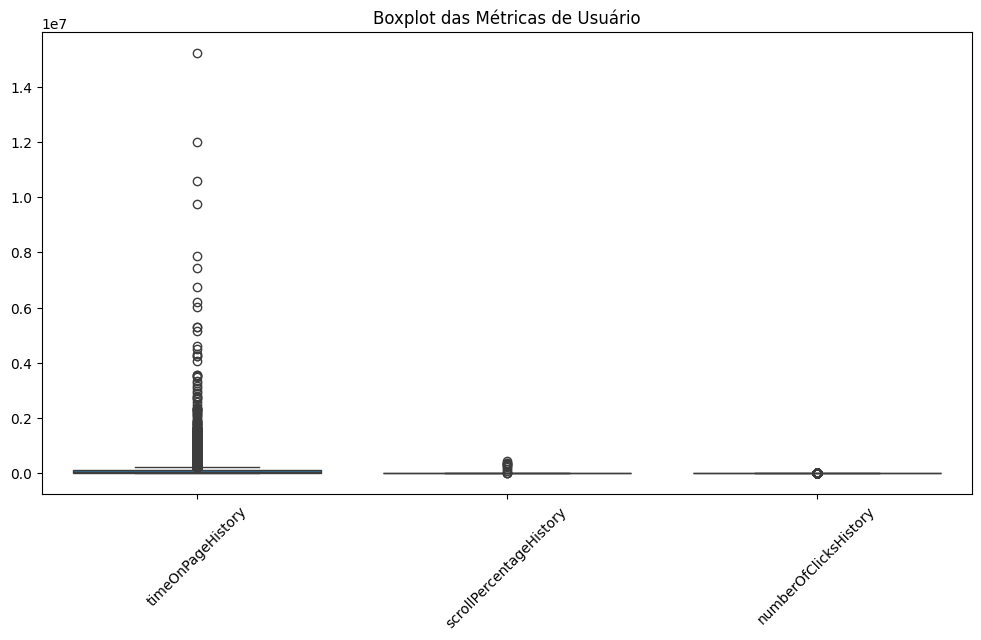

In [14]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=df_sample[['timeOnPageHistory', 'scrollPercentageHistory', 'numberOfClicksHistory']])
plt.xticks(rotation=45)
plt.title("Boxplot das Métricas de Usuário")
plt.savefig("/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/figures/boxplot_metrica_usuario.png", dpi=300, bbox_inches='tight')
plt.show()

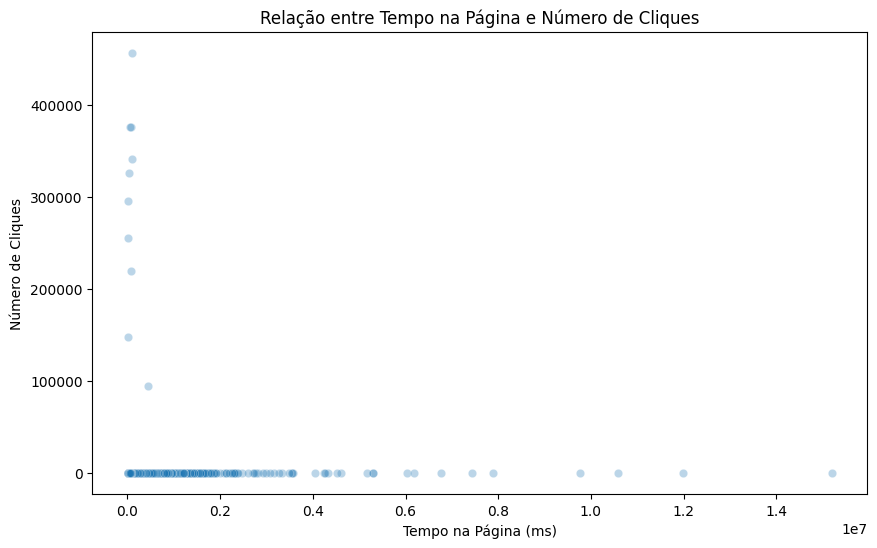

In [16]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_sample, x="timeOnPageHistory", y="scrollPercentageHistory", alpha=0.3)

plt.title("Relação entre Tempo na Página e Número de Cliques")
plt.xlabel("Tempo na Página (ms)")
plt.ylabel("Número de Cliques")
plt.savefig("/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/figures/relation_time_and_scroll.png", dpi=300, bbox_inches='tight')
plt.show()

In [35]:
#Limpando dados onde timeOnPageHistory possui valores:
#Menor que 10s, o conteúdo não era relevante, clicado na página por acidente, Títulos ou descrições que não atraíram
#Maior que 1h (Não vou fazer isso por enquanto), posso considerar que se a pessoa esqueceu aberto talvez foi para ler mais tarde

def clean_data(row, scroll_threshold=10, min_time_threshold=10000, max_time_threshold=1000000, max_click_in_page_threshold = 200):
    #Excluindo timeOnPageHistory < 10s
    #Excluindo timeOnPageHistory > 1000s (Pois o usuário pode ter deixado aberto e esquecido)
    #Excluindo Baixa acertividade na noticia baseado no interesse do srool
    delete_index = [i for i, (scrollInPage, timeInPage, clickInPage) in enumerate(zip(row['scrollPercentageHistory'], row['timeOnPageHistory'], row['numberOfClicksHistory'] ))
                    if  (scrollInPage < scroll_threshold) or 
                        (scrollInPage >= scroll_threshold and timeInPage < min_time_threshold) or
                        (timeInPage > max_time_threshold) or
                        (clickInPage > max_click_in_page_threshold)]
    
    #Resolver o if acima, n pode ser or
    # Se houver índices a excluir
    if len(delete_index) > 0:
        if len(delete_index) == len(row['timeOnPageHistory']):
            return pd.Series()

        for col in list_columns_with_same_size:
            row[col] = [line for i, line in enumerate(row[col]) if i not in delete_index]

        row['historySize'] = int(row['historySize'] - len(delete_index))

    return row
        

usersInfo = usersInfo.apply(clean_data, axis=1)
usersInfo = usersInfo.dropna()

In [53]:
usersInfo.to_csv('/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/files_modify/usersInfo_pre1.csv', index=False, encoding='utf-8')
newsInfo.to_csv('/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/files_modify/newsInfo_pre1.csv', index=False, encoding='utf-8')


In [ ]:
print(usersInfo.shape)
print(newsInfo.shape)


In [25]:
usersInfo = pd.read_csv("/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/TestesJupiterNotebook/usersInfo_pre1.csv")
#newsInfo = pd.read_csv("/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/TestesJupiterNotebook/usersInfo_pre1.csv.csv")

In [29]:
usersInfo["numberOfClicksHistory"][0]


'[4, 41, 6, 0, 0, 1, 1, 1, 21, 79, 25, 1]'

In [26]:
usersInfo

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory
0,e5f68d5e7cdbe56d6984589b4baa6ebfc5e8a8a918e57d...,Logged,12.0,"[""50028008-aa11-4519-9d75-452c84dd27fb"", "" d03...","[1657264136826, 1657552410329, 1657552529759, ...","[4, 41, 6, 0, 0, 1, 1, 1, 21, 79, 25, 1]","[10081, 70000, 12216, 90000, 161291, 346113, 7...","[16.34, 79.35, 13.36, 37.95, 73.83, 68.98, 51....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,3a3b7f25a30a5a17a530685545e3a0be38cee0c6904c42...,Logged,93.0,"[""561850c2-9ade-4985-bf36-402abf02153d"", "" c4a...","[1656683068549, 1656692064526, 1656696714488, ...","[6, 9, 19, 20, 14, 9, 13, 21, 9, 20, 50, 16, 1...","[28139, 70000, 230000, 120000, 78858, 50000, 3...","[21.82, 51.35, 93.4, 81.35, 78.47, 37.43, 27.3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,ea6728ebc30782516a7593a1143c47dc59428e1649c048...,Logged,6.0,"["" 9a7695fe-83b3-44f3-aa45-a02d75e5052a"", "" 5c...","[1657834031446, 1657895788959, 1658329023059, ...","[0, 3, 2, 29, 8, 13]","[70000, 10928, 10112, 165124, 30000, 60000]","[81.2, 24.18, 16.33, 44.95, 16.09, 30.43]","[1, 1, 1, 1, 2, 1]"
3,f909c50558c01ab790636e1b1918e6a5965bdcc271a860...,Non-Logged,19.0,"[""598ed114-fd5a-4d82-90d8-f1e893cb0892"", "" 921...","[1656872519048, 1656895522162, 1656952360252, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, ...","[30007, 43153, 41626, 39675, 12100, 40000, 488...","[12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,9725352f759a73aa977cb5eff2596a5f683fcd0c753200...,Logged,32.0,"[""80753b6f-d65c-4962-9f2e-ef582cce0de0"", "" 975...","[1656762806361, 1656764327095, 1656782770362, ...","[6, 16, 0, 0, 6, 1, 1, 0, 0, 0, 0, 0, 3, 1, 5,...","[100000, 110000, 50000, 68291, 60000, 10000, 9...","[49.25, 66.86, 71.52, 59.33, 37.27, 14.77, 54....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...
545791,2577444c60e7e1894b120b966031b66c08f696101a085f...,Non-Logged,4.0,"[""82206221-05a0-4f89-aa10-e8c8dc0cc418"", "" bfb...","[1656864715643, 1658103612200, 1659107526581, ...","[36, 50, 1, 7]","[20000, 74626, 10000, 10000]","[40.53, 45.76, 11.34, 18.25]","[1, 2, 1, 1]"
545792,4325f2bbeed10d10868190e2f66e700621c04b63eebefd...,Non-Logged,1.0,"[""34a692f5-46f7-482a-918d-c1094fb314d5""]",[1657392105652],[28],[74694],[12.42],[6]
545793,0ca60effb4a0f595cf838c95a4d3a417f02bb7edeaf659...,Non-Logged,3.0,"[""08126a08-b06e-4dc2-9c70-26922c14f465"", "" cde...","[1660154775574, 1660160550596, 1660162482895]","[2, 7, 1]","[54143, 37776, 18911]","[33.27, 50.1, 14.95]","[2, 1, 1]"
545794,c07adf21d372ebc50752555fdfbc949e164d98d06d094f...,Logged,14.0,"[""bc625312-eb34-4f23-a281-499f1da183b4"", "" cee...","[1657201926509, 1657202207327, 1657541602224, ...","[1, 0, 3, 0, 0, 0, 0, 1, 6, 0, 1, 8, 25, 6]","[50000, 71013, 160000, 40000, 68795, 20008, 47...","[50.45, 50.45, 49.19, 32.09, 14.15, 26.19, 25....","[1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1]"


In [14]:
import re
import spacy
import nltk
import pandas as pd
import string
from nltk.corpus import stopwords

# Carregar modelo de linguagem para lematização
nlp = spacy.load("pt_core_news_md")

# Baixar stopwords em português
nltk.download('stopwords')
stopwords_pt = set(stopwords.words('portuguese'))

# Função para remover acentos
def remove_accent(text):
    return re.sub(r"[áàãâäéèêëíìîïóòôõöúùûüç]", 
                  lambda m: "aaaaaeeeeiiiiooooouuuuc"["áàãâäéèêëíìîïóòôõöúùûüç".index(m.group())], 
                  text)

# Função otimizada de pré-processamento
def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):  
        return text

    text = remove_accent(text.lower())  # Remove acentos e coloca em minúsculas
    text = re.sub(r"\d+º?", "", text)  # Remove números

    # Tokenização + lematização
    #doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if token.text not in stopwords_pt and token.text not in string.punctuation]
    
    doc = nlp(text)
    tokens = [token.text for token in doc if token.text not in stopwords_pt and token.text not in string.punctuation]

    return " ".join(tokens)



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rodrigo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#newsInfo["processed_text"] = (newsInfo["title"] + " " + newsInfo["caption"]).map(preprocess_text)
b = newsInfo[0:50]
a = (b["title"] + " " + b["caption"]).map(preprocess_text)

In [26]:
import subprocess

subprocess.run(["python", "-m", "spacy", "download", "pt_core_news_md"], cwd="/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/models")

/usr/bin/python: No module named spacy


CompletedProcess(args=['python', '-m', 'spacy', 'download', 'pt_core_news_md'], returncode=1)

In [ ]:
import re
import spacy
import nltk
import pandas as pd
import string
from nltk.corpus import stopwords
from multiprocessing import Pool, cpu_count

# Carregar modelo SpaCy uma única vez
nlp = spacy.load("pt_core_news_md", disable=["ner", "parser"])  # Desativa partes desnecessárias

# Baixar stopwords em português
nltk.download('stopwords')
stopwords_pt = set(stopwords.words('portuguese'))

# Função para remover acentos
def remove_accent(text):
    return re.sub(r"[áàãâäéèêëíìîïóòôõöúùûüç]", 
                  lambda m: "aaaaaeeeeiiiiooooouuuuc"["áàãâäéèêëíìîïóòôõöúùûüç".index(m.group())], 
                  text)

# Função otimizada de pré-processamento
def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):  
        return ""

    text = remove_accent(text.lower())  # Remove acentos e coloca em minúsculas
    text = re.sub(r"\d+º?", "", text)  # Remove números

    # Tokenização + remoção de stopwords e pontuação
    doc = nlp(text)
    tokens = [token.text for token in doc if token.text not in stopwords_pt and token.text not in string.punctuation]

    return " ".join(tokens)

# Função para processamento paralelo
def process_in_parallel(data, num_workers=None):
    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)  # Usa todas as CPUs menos 1

    with Pool(num_workers) as pool:
        processed_texts = pool.map(preprocess_text, data)

    return processed_texts

# Concatenar título + legenda antes do processamento
text_data = (newsInfo["title"] + " " + newsInfo["caption"]).tolist()

# Processar com multiprocessing
newsInfo["processed_text"] = process_in_parallel(text_data)

# Exibir amostra
print(newsInfo.head())

In [5]:
text_test = newsInfo["title"][0] + " " + newsInfo["caption"][0]
text_test

'Caso Bruno e Dom: 3º suspeito tem prisão temporária decretada pela Justiça do AM Jeferson da Silva Lima foi escoltado por agentes da Polícia Federal ao Fórum de Justiça do município para a audiência de custódia'

In [2]:
pre = preprocess_text(text_test)
print(pre)

NameError: name 'preprocess_text' is not defined

fasttext

In [ ]:
import fasttext

# Carregar o modelo treinado
model = fasttext.load_model("/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/Models/cc.pt.300.bin")

similar_words = model.get_nearest_neighbors("política", k=5)  # Top 5 palavras mais próximas
for similarity, word in similar_words:
    print(f"{word}: {similarity}")

In [1]:
import fasttext
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Carregar o modelo treinado
model = fasttext.load_model("/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/models/cc.pt.300.bin")

noticias_lidas = [
    "Economia do Brasil cresce com novo plano financeiro"
]

# Banco de notícias para recomendação
noticias_disponiveis = [
    "Governo lança novo plano econômico para o país",
    "Ministro da economia apresenta pacote de reformas",
    "Nova tecnologia de inteligência artificial revoluciona o mercado",
    "Time brasileiro vence campeonato internacional de futebol",
    "Pesquisa científica descobre novo tratamento para doenças raras"
]

def get_text_vector(text):
    words = text.split()
    word_vectors = [model.get_word_vector(word) for word in words if word in model.words]
    if not word_vectors:
        return np.zeros(300)  # Retorna vetor zero se nenhuma palavra for encontrada
    return np.mean(word_vectors, axis=0)  # Média dos vetores


vetores_lidas = [get_text_vector(n) for n in noticias_lidas]
vetores_disponiveis = [get_text_vector(n) for n in noticias_disponiveis]


from datetime import datetime
print(datetime.now().strftime("%H:%M:%S"))
recomendacoes = []
for i, vetor_disponivel in enumerate(vetores_disponiveis):
    max_similaridade = max(
        cosine_similarity([vetor_disponivel], vetores_lidas)[0]
    )  # Pega a maior similaridade com qualquer notícia lida
    recomendacoes.append((noticias_disponiveis[i], max_similaridade))

# Ordenar recomendações pela maior similaridade
recomendacoes.sort(key=lambda x: x[1], reverse=True)
print(datetime.now().strftime("%H:%M:%S"))

# Mostrar recomendações
print("\nRecomendações de notícias:")
for noticia, score in recomendacoes:
    print(f"{noticia} (similaridade: {score:.2f})")



21:11:47
21:11:47

Recomendações de notícias:
Governo lança novo plano econômico para o país (similaridade: 0.85)
Nova tecnologia de inteligência artificial revoluciona o mercado (similaridade: 0.71)
Pesquisa científica descobre novo tratamento para doenças raras (similaridade: 0.60)
Time brasileiro vence campeonato internacional de futebol (similaridade: 0.57)
Ministro da economia apresenta pacote de reformas (similaridade: 0.56)


In [2]:
import pandas as pd
newsInfo_process = pd.read_csv("/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/TestesJupiterNotebook/newsInfo_process2.csv")

In [3]:
newsInfo_process.head(1)

,page,url,issued,modified,title,body,caption,preprocesstext,embeddings_fasttext
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...,caso bruno dom suspeito prisao temporaria de...,[-3.57559137e-02 -3.99057474e-03 4.78643738e-...


In [ ]:
newsInfo_process["preprocesstext"].tolist()

In [4]:
import concurrent.futures
import fasttext
import numpy as np

# Carregando o modelo FastText
model = fasttext.load_model("/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/models/cc.pt.300.bin")

# Exemplo de notícias (substitua com seu próprio conjunto)
noticias = newsInfo_process["preprocesstext"].tolist()  # Exemplo com 30 notícias

def create_embedding_chunk(chunk):
    """Função global para criar embeddings para um pedaço de notícias."""
    # Limpar quebras de linha antes de passar para o modelo
    cleaned_chunk = [news.replace('\n', ' ') for news in chunk]  # Remove as quebras de linha
    return [model.get_sentence_vector(news) for news in cleaned_chunk]

def create_embeddings_parallel():
    """Função para criar embeddings em paralelo."""
    # Dividindo as notícias em partes menores (chunks)
    chunk_size = max(1, len(noticias) // 4)  # Ajuste para garantir que chunk_size não seja zero
    chunks = [noticias[i:i + chunk_size] for i in range(0, len(noticias), chunk_size)]
    
    embeddings = []
    
    # Usando múltiplos processos para gerar os embeddings
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # O map recebe os chunks e aplica a função em cada parte
        results = executor.map(create_embedding_chunk, chunks)
    
    # Juntando todos os resultados
    for result in results:
        embeddings.extend(result)
    
    return np.array(embeddings)

# Gerar os embeddings e salvar em um arquivo .txt
array = create_embeddings_parallel()
file_path = '/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/TestesJupiterNotebook/embeddings.txt'

# Salvando os embeddings em um arquivo .txt
np.savetxt(file_path, array, delimiter=",")

print(f"Embeddings salvos em {file_path}")


Embeddings salvos em /home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/TestesJupiterNotebook/embeddings.txt


In [23]:
newsInfo_process.shape

(255603, 9)

In [5]:
newsInfo_process["embeddings_fasttext"] = list(array)

In [7]:
newsInfo_process.to_csv('/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/TestesJupiterNotebook/newsInfo_process2.csv', index=False, encoding='utf-8')

In [ ]:
newsInfo_process.head(1)

In [ ]:
test_news

In [33]:
test_news = newsInfo_process[['page', 'url', 'issued', 'modified', 'title', 'body', 'caption',
       'preprocesstext']]

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=300)
tfidf_matrix = vectorizer.fit_transform(test_news["preprocesstext"])

In [69]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Exemplo de DataFrame com notícias
data = {
    'id': [1, 2, 3, 4, 5, 6, 7],
    'noticia': [
        "Notícia sobre política internacional.",
        "Notícia sobre economia e finanças.",
        "Notícia sobre o avanço das tecnologias.",
        "Notícia sobre esportes e futebol.",
        "Notícia sobre saúde e bem-estar.",
        "Notícia sobre economia e internaciona.",
        "Notícia sobre ciência e inovações."
    ]
}

df = pd.DataFrame(data)

# Dividir as notícias em lidas e não lidas
# Vamos assumir que as notícias de id 1 e 2 foram lidas, e as de 3 a 7 não lidas.
lidas = df[df['id'].isin([1])]
nao_lidas = df[df['id'].isin([3, 4, 5, 6, 7])]

# Passo 1: Gerar o vetor TF-IDF para as notícias não lidas (limitado a 300 características)
vectorizer = TfidfVectorizer(stop_words="english", max_features=300)

# Combina as notícias não lidas para calcular o TF-IDF
tfidf_matrix_nao_lidas = vectorizer.fit_transform(nao_lidas['noticia'])

# Passo 2: Gerar o vetor TF-IDF para as notícias lidas
tfidf_matrix_lidas = vectorizer.transform(lidas['noticia'])

# Passo 3: Calcular a similaridade entre as notícias lidas e não lidas
similaridade = cosine_similarity(tfidf_matrix_nao_lidas, tfidf_matrix_lidas)

# Exibir as similaridades
print("Similaridade entre as notícias não lidas e lidas:")
print(similaridade)

# Passo 4: Selecionar a notícia não lida mais similar a cada notícia lida
# Vamos recomendar as notícias não lidas com maior similaridade à notícia lida mais próxima
# Em vez de apenas mostrar a similaridade, vamos classificar as notícias não lidas
# com base na similaridade média com todas as notícias lidas

# Calcular a similaridade média de cada notícia não lida com todas as notícias lidas
similaridade_media = similaridade.mean(axis=1)

# Adicionar a similaridade média ao DataFrame das notícias não lidas
nao_lidas['similaridade_media'] = similaridade_media

# Ordenar as notícias não lidas pela similaridade média, da maior para a menor
recomendadas = nao_lidas.sort_values(by='similaridade_media', ascending=False)

# Exibir as notícias recomendadas (ordenadas pela maior similaridade)
print("\nNotícias recomendadas:")
print(recomendadas[['id', 'noticia', 'similaridade_media']])


Similaridade entre as notícias não lidas e lidas:
[[0.36258882]
 [0.43016528]
 [0.36258882]
 [0.43016528]
 [0.43016528]]

Notícias recomendadas:
   id                                  noticia  similaridade_media
3   4        Notícia sobre esportes e futebol.            0.430165
6   7       Notícia sobre ciência e inovações.            0.430165
5   6   Notícia sobre economia e internaciona.            0.430165
2   3  Notícia sobre o avanço das tecnologias.            0.362589
4   5         Notícia sobre saúde e bem-estar.            0.362589


/tmp/ipykernel_35355/3972751553.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nao_lidas['similaridade_media'] = similaridade_media


In [10]:
df["id"]

[1, 2, 3, 4, 5, 6, 7]

In [1]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Exemplo de DataFrame com notícias
data = {
    'id': [1, 2, 3, 4, 5, 6, 7],
    'noticia': [
        "Notícia sobre política internacional.",
        "Notícia sobre economia e finanças.",
        "Notícia sobre o avanço das tecnologias.",
        "Notícia sobre esportes e futebol.",
        "Notícia sobre saúde e bem-estar.",
        "Notícia sobre economia e internacional.",
        "Notícia sobre ciência e inovações."
    ]
}

df = pd.DataFrame(data)

# Simulando quais foram lidas e não lidas
lidas = df[df['id'].isin([1])]
nao_lidas = df[df['id'].isin([3, 4, 5, 6, 7])]

### 1️⃣ Treinar e salvar o modelo TF-IDF e matriz das não lidas (Somente na primeira vez)
vectorizer = TfidfVectorizer(stop_words="english", max_features=300)
tfidf_matrix_nao_lidas = vectorizer.fit_transform(data['noticia'])

# Salvar modelo e matriz TF-IDF
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("tfidf_nao_lidas.pkl", "wb") as f:
    pickle.dump(tfidf_matrix_nao_lidas, f)

print("Modelo e matriz TF-IDF das não lidas salvos!")

### 2️⃣ Carregar modelo salvo e matriz TF-IDF para evitar recomputação
with open("tfidf_vectorizer.pkl", "rb") as f:
    loaded_vectorizer = pickle.load(f)

with open("tfidf_nao_lidas.pkl", "rb") as f:
    tfidf_matrix_nao_lidas = pickle.load(f)

# Transformar somente as notícias lidas
tfidf_matrix_lidas = loaded_vectorizer.transform(lidas['noticia'])

# Calcular a similaridade
similaridade = cosine_similarity(tfidf_matrix_nao_lidas, tfidf_matrix_lidas)

# Calcular a média da similaridade para cada notícia não lida
similaridade_media = similaridade.mean(axis=1)

# Adicionar a similaridade média ao DataFrame
nao_lidas = nao_lidas.copy()
nao_lidas['similaridade_media'] = similaridade_media


# Ordenar as recomendações e pegar no máximo 5
recomendadas = nao_lidas.sort_values(by='similaridade_media', ascending=False).head(5)

# Exibir recomendações com ID
print("\nNotícias recomendadas:")
print(recomendadas[['id', 'noticia', 'similaridade_media']])


Modelo e matriz TF-IDF das não lidas salvos!


ValueError: Length of values (7) does not match length of index (5)

In [6]:
embedding_vectors = []
for i in range(tfidf_matrix.shape[0]):
    embedding_vector = tfidf_matrix[i].toarray().flatten()  # Converte para vetor 1D
    embedding_vectors.append(embedding_vector)
        

In [81]:
df2.shape

(5, 1)

In [7]:
newsInfo_process["embeddings_tfidf"] = embedding_vectors

In [ ]:
newsInfo_process[["page","embeddings_tfidf"]]

In [9]:
newsInfo_process.to_csv('/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/TestesJupiterNotebook/newsInfo_process3.csv', index=False, encoding='utf-8')

In [4]:
newsInfo_process = pd.read_csv("/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/TestesJupiterNotebook/news_preprocess.csv")

In [7]:
newsInfo_process["embeddings_tfidf"][0:3]

0    [0.         0.         0.         0.         0...
1    [0.         0.         0.         0.         0...
2    [0.         0.         0.         0.         0...
Name: embeddings_tfidf, dtype: object

In [28]:
read_embeddings = newsInfo_process["embeddings_tfidf"][0:3]
unread_embeddings= newsInfo_process["embeddings_tfidf"][3:6]


read_embeddings = np.array(read_embeddings.tolist())
unread_embeddings = np.array(unread_embeddings.tolist()) 


In [30]:
unread_embeddings = np.array(unread_embeddings, dtype=np.float32)
read_embeddings = np.array(read_embeddings, dtype=np.float32)

ValueError: could not convert string to float: np.str_('[0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.29302957 0.\n 0.         0.26424313 0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.3675646  0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.3835596  0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.30130129 0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.68651662 0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.        ]')

In [22]:
similarity_matrix = cosine_similarity(unread_embeddings, read_embeddings)


ValueError: could not convert string to float: np.str_('[0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.29302957 0.\n 0.         0.26424313 0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.3675646  0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.3835596  0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.30130129 0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.68651662 0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.\n 0.         0.         0.         0.         0.         0.        ]')

In [ ]:
print(type(read_embeddings))
print(read_embeddings[0]) 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_scores = []
for unread_id, unread_embedding in unread_embeddings.items():
    avg_similarity = 0
    for read_id, read_embedding in read_embeddings.items():
        # Calcula a similaridade entre a notícia lida e não lida
        avg_similarity += cosine_similarity([read_embedding], [unread_embedding])[0][0]
    # Calcula a média das similaridades para a notícia não lida
    similarity_scores.append((unread_id, avg_similarity / len(read_embeddings)))

In [ ]:
recommendations = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
recommendations[:5]

In [12]:
noticias_lidas = [
    "Economia do Brasil cresce com novo plano financeiro"
]

# Banco de notícias para recomendação
noticias_disponiveis = [
    "Governo lança novo plano econômico para o país",
    "Ministro da economia apresenta pacote de reformas",
    "Nova tecnologia de inteligência artificial revoluciona o mercado",
    "Time brasileiro vence campeonato internacional de futebol",
    "Pesquisa científica descobre novo tratamento para doenças raras"
]

In [13]:
def get_text_vector(text):
    words = text.split()
    word_vectors = [model.get_word_vector(word) for word in words if word in model.words]
    if not word_vectors:
        return np.zeros(300)  # Retorna vetor zero se nenhuma palavra for encontrada
    return np.mean(word_vectors, axis=0)  # Média dos vetores

In [14]:
vetores_lidas = [get_text_vector(n) for n in noticias_lidas]
vetores_disponiveis = [get_text_vector(n) for n in noticias_disponiveis]

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

recomendacoes = []
for i, vetor_disponivel in enumerate(vetores_disponiveis):
    max_similaridade = max(
        cosine_similarity([vetor_disponivel], vetores_lidas)[0]
    )  # Pega a maior similaridade com qualquer notícia lida
    recomendacoes.append((noticias_disponiveis[i], max_similaridade))

# Ordenar recomendações pela maior similaridade
recomendacoes.sort(key=lambda x: x[1], reverse=True)

# Mostrar recomendações
print("\nRecomendações de notícias:")
for noticia, score in recomendacoes:
    print(f"{noticia} (similaridade: {score:.2f})")


Recomendações de notícias:
Governo lança novo plano econômico para o país (similaridade: 0.85)
Nova tecnologia de inteligência artificial revoluciona o mercado (similaridade: 0.71)
Pesquisa científica descobre novo tratamento para doenças raras (similaridade: 0.60)
Time brasileiro vence campeonato internacional de futebol (similaridade: 0.57)
Ministro da economia apresenta pacote de reformas (similaridade: 0.56)


In [18]:
!python3.10 -m pip install transformers torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.6.0-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux201

In [1]:
import torch
import numpy as np
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Carregar o tokenizer e o modelo BERTimbau
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = BertModel.from_pretrained("neuralmind/bert-base-portuguese-cased")

/home/rodrigo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name '_imaging' from 'PIL' (/usr/lib/python3/dist-packages/PIL/__init__.py)

In [ ]:
# Função para gerar embeddings usando BERTimbau
def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        output = model(**tokens)
    
    return output.last_hidden_state[:, 0, :].squeeze().numpy()  # Pegamos o vetor da [CLS] token

noticias = [
    "Governo lança novo plano econômico para o país",
    "Ministro da economia apresenta pacote de reformas",
    "Nova tecnologia de inteligência artificial revoluciona o mercado",
    "Time brasileiro vence campeonato internacional de futebol",
    "Pesquisa científica descobre novo tratamento para doenças raras"
]

# Criar embeddings das notícias usando BERTimbau
noticias_embeddings = np.array([get_bert_embedding(noticia) for noticia in noticias])

noticia_usuario = "Economia do Brasil cresce com novo plano financeiro"
embedding_usuario = get_bert_embedding(noticia_usuario)

# Calcular similaridade entre a notícia do usuário e todas as notícias disponíveis
similaridades = cosine_similarity([embedding_usuario], noticias_embeddings)[0]

# Ordenar notícias por similaridade
noticias_recomendadas = sorted(zip(noticias, similaridades), key=lambda x: x[1], reverse=True)

# Exibir as 3 melhores recomendações
print("🔹 Notícias recomendadas para você:")
for noticia, similaridade in noticias_recomendadas[:3]:
    print(f" - {noticia} (Similaridade: {similaridade:.2f})")

In [2]:
import pandas as pd

# Dados das notícias
noticias = pd.DataFrame({
    'id': [1, 2, 3, 4, 5],
    'titulo': ['Notícia A', 'Notícia B', 'Notícia C', 'Notícia D', 'Notícia E'],
    'conteudo': [
        'Texto completo da notícia A...',
        'Texto completo da notícia B...',
        'Texto completo da notícia C...',
        'Texto completo da notícia D...',
        'Texto completo da notícia E...'
    ]
})

# Histórico do usuário
historico_usuario = pd.DataFrame({
    'id_noticia': [1, 2, 3],  # IDs das notícias visitadas
    'timeOnPageHistory': [120, 30, 300],  # Tempo em segundos
    'scrollPercentageHistory': [80, 20, 95],  # Porcentagem de scroll
    'numberOfClicksHistory': [3, 1, 5],  # Número de cliques
    'pageVisitsCountHistory': [2, 1, 3],  # Número de visitas
    'timestampHistory': [2, 10, 1]  # Horas desde a visita
})

In [3]:
from datetime import datetime
import math

# Pesos para cada métrica de engajamento
pesos = {
    'timeOnPageHistory': 0.5,
    'scrollPercentageHistory': 0.3,
    'numberOfClicksHistory': 0.1,
    'pageVisitsCountHistory': 0.1
}

# Função para calcular o decay temporal
def calcular_decay(tempo_em_horas):
    return math.exp(-0.1 * tempo_em_horas)  # Ajuste o fator 0.1 conforme necessário

# Calcular o engajamento ponderado
historico_usuario['engagement_score'] = (
    historico_usuario['timeOnPageHistory'] * pesos['timeOnPageHistory'] +
    historico_usuario['scrollPercentageHistory'] * pesos['scrollPercentageHistory'] +
    historico_usuario['numberOfClicksHistory'] * pesos['numberOfClicksHistory'] +
    historico_usuario['pageVisitsCountHistory'] * pesos['pageVisitsCountHistory']
)

# Aplicar decay temporal
historico_usuario['weighted_engagement'] = historico_usuario.apply(
    lambda row: row['engagement_score'] * calcular_decay(row['timestampHistory']),
    axis=1
)

print(historico_usuario)

   id_noticia  timeOnPageHistory  scrollPercentageHistory  \
0           1                120                       80   
1           2                 30                       20   
2           3                300                       95   

   numberOfClicksHistory  pageVisitsCountHistory  timestampHistory  \
0                      3                       2                 2   
1                      1                       1                10   
2                      5                       3                 1   

   engagement_score  weighted_engagement  
0              84.5            69.182749  
1              21.2             7.799044  
2             179.3           162.237349  


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Treinar o TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(noticias['conteudo'])

# Verificar o shape da matriz TF-IDF
print(tfidf_matrix.shape)  # (número de notícias, número de termos)

(5, 4)


In [20]:
import numpy as np

# Obter os índices das notícias visitadas no histórico
indices_noticias_visitadas = [noticias.index[noticias['id'] == id].tolist()[0] for id in historico_usuario['id_noticia']]

# Calcular o vetor de perfil do usuário
user_profile = np.zeros(tfidf_matrix.shape[1])  # Inicializar com zeros


In [21]:
user_profile

array([0., 0., 0., 0.])

In [19]:
for idx in range(tfidf_matrix.shape[0]):
    print(tfidf_matrix[idx])

  (np.int32(0), np.int32(3))	0.5
  (np.int32(0), np.int32(0))	0.5
  (np.int32(0), np.int32(1))	0.5
  (np.int32(0), np.int32(2))	0.5
  (np.int32(0), np.int32(3))	0.5
  (np.int32(0), np.int32(0))	0.5
  (np.int32(0), np.int32(1))	0.5
  (np.int32(0), np.int32(2))	0.5
  (np.int32(0), np.int32(3))	0.5
  (np.int32(0), np.int32(0))	0.5
  (np.int32(0), np.int32(1))	0.5
  (np.int32(0), np.int32(2))	0.5
  (np.int32(0), np.int32(3))	0.5
  (np.int32(0), np.int32(0))	0.5
  (np.int32(0), np.int32(1))	0.5
  (np.int32(0), np.int32(2))	0.5
  (np.int32(0), np.int32(3))	0.5
  (np.int32(0), np.int32(0))	0.5
  (np.int32(0), np.int32(1))	0.5
  (np.int32(0), np.int32(2))	0.5


In [15]:
for idx, engagement in zip(indices_noticias_visitadas, historico_usuario['weighted_engagement']):
    print(idx)
    print(tfidf_matrix[idx].toarray().flatten())
    print(engagement)
    print(tfidf_matrix[idx].toarray().flatten() * engagement)
    user_profile += tfidf_matrix[idx].toarray().flatten() * engagement
    print(user_profile)

# Normalizar o vetor de perfil
user_profile /= np.linalg.norm(user_profile)
print(user_profile)

0
[0.5 0.5 0.5 0.5]
69.18274863508947
[34.59137432 34.59137432 34.59137432 34.59137432]
[35.09137432 35.09137432 35.09137432 35.09137432]
1
[0.5 0.5 0.5 0.5]
7.799044152834578
[3.89952208 3.89952208 3.89952208 3.89952208]
[38.99089639 38.99089639 38.99089639 38.99089639]
2
[0.5 0.5 0.5 0.5]
162.23734905384754
[81.11867453 81.11867453 81.11867453 81.11867453]
[120.10957092 120.10957092 120.10957092 120.10957092]
[0.5 0.5 0.5 0.5]


In [3]:
import os
import pandas as pd

def split_csv_by_size(file_path, max_size_mb=25, output_dir="newsInfo_pre"):
    # Criar diretório de saída se não existir
    os.makedirs(output_dir, exist_ok=True)

    # Carregar o CSV em chunks para evitar alto consumo de memória
    chunk_size = 10000  # Número inicial de linhas por chunk
    chunk_list = []
    total_size = 0
    file_count = 1

    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        chunk_list.append(chunk)
        total_size += chunk.memory_usage(deep=True).sum()

        # Se o tamanho total do chunk for maior que o limite, salva e inicia um novo
        if total_size >= max_size_mb * 1024 * 1024:
            output_file = os.path.join(output_dir, f"part_{file_count}.csv")
            pd.concat(chunk_list).to_csv(output_file, index=False)
            print(f"Arquivo salvo: {output_file}")

            # Resetar variáveis
            chunk_list = []
            total_size = 0
            file_count += 1

    # Salvar o último arquivo, se houver dados restantes
    if chunk_list:
        output_file = os.path.join(output_dir, f"part_{file_count}.csv")
        pd.concat(chunk_list).to_csv(output_file, index=False)
        print(f"Arquivo salvo: {output_file}")

# Exemplo de uso
split_csv_by_size("/home/rodrigo/Vídeos/Datathon/Datathon - FIAP+GloboPlay/files_process/usersInfo_pre.csv")

Arquivo salvo: newsInfo_pre/part_1.csv
Arquivo salvo: newsInfo_pre/part_2.csv
Arquivo salvo: newsInfo_pre/part_3.csv
Arquivo salvo: newsInfo_pre/part_4.csv
Arquivo salvo: newsInfo_pre/part_5.csv
Arquivo salvo: newsInfo_pre/part_6.csv
Arquivo salvo: newsInfo_pre/part_7.csv
Arquivo salvo: newsInfo_pre/part_8.csv
Arquivo salvo: newsInfo_pre/part_9.csv
Arquivo salvo: newsInfo_pre/part_10.csv
Arquivo salvo: newsInfo_pre/part_11.csv
Arquivo salvo: newsInfo_pre/part_12.csv
Arquivo salvo: newsInfo_pre/part_13.csv
Arquivo salvo: newsInfo_pre/part_14.csv
Arquivo salvo: newsInfo_pre/part_15.csv
